In [47]:
import torch
import torch.nn as nn
import random
import pandas as pd
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'


print('Selected available:', device)

Selected available: cuda


In [48]:
import json
from collections import OrderedDict
from utils.Vocabulary import Vocabulary

min_freq = 75
eng_vocab_file = "../data-sets/vocab_eng.json"
nld_vocab_file = "../data-sets/vocab_nld.json"

with open(eng_vocab_file, mode="r") as f:
    eng_dict = json.load(f, object_pairs_hook=OrderedDict)

with open(nld_vocab_file, mode="r") as f:
    nld_dict = json.load(f, object_pairs_hook=OrderedDict)

eng_vocab = Vocabulary(eng_dict, min_freq=min_freq)
nld_vocab = Vocabulary(nld_dict, min_freq=min_freq)

print("English vocabulary:", eng_vocab)
print("Dutch vocabulary:", nld_vocab)

print()
print("Index of token \"The\":", eng_vocab.token_to_index["the"])
print("Token on index 24:", eng_vocab.index_to_token[24])

English vocabulary: Vocabulary with 58713 tokens.
Dutch vocabulary: Vocabulary with 92497 tokens.

Index of token "The": 7
Token on index 24: be


In [49]:
''' Hyperparameters: '''

# Model parameters
emb_dim       = 100
hidden_size   = 300 # The same hidden size for encoder and decoder
num_layers    =   3
dropout       =   0

# Training parameters
epochs        = 4
batch_size    = 384 # Larger batches reduce noise, and thus approach the true gradient better
learning_rate = 0.0001 # Smaller learning rates update the function less, and will reduce noise
weight_decay  = 0.00005 # Penalize complexity (large weights) to generalize better

# Noisy gradients are going to have a regularizing effect, they make improving the training loss harder
# because part of the loss reduction we had in the past is going to get destroyed by a step in a slightly
# random direction.abs

# Noiseless gradients are going to enable higher learning rates until you reach issues with loss curvature, so
# you can make more progress on the loss per iteration at the expense of more computation each step.


In [50]:
from utils.CustomDataSet import CustomDataSet
from torch.utils.data import DataLoader, random_split

nrows = 10000 # 5000000
train_split = 0.9
file = "../data-sets/filtered_and_tokenized_sentences(1).csv"

dataset = CustomDataSet(file, output_size=20, input_vocab=eng_vocab, target_vocab=nld_vocab, nrows=nrows)

''' Calculate split sizes '''
dataset_size = len(dataset)
train_size = int(train_split * dataset_size)
test_size = dataset_size - train_size

''' Split the dataset up '''
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

''' Create Data Loaders '''
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)



print("Train data:", train_size)
print("Test data:", test_size)

Train data: 9000
Test data: 1000


In [51]:
from RNN.Seq2Seq import Seq2Seq

''' Construct the model '''
model = Seq2Seq(
    len(eng_vocab),
    len(nld_vocab),
    emb_dim,
    hidden_size,
    hidden_size,
    num_layers,
    dropout,
).to(device)



''' Display where all the model's parameters are exactly located '''
def count_params(module, indent=0, module_name=""):
    total_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

    name_str = f"{module_name} ({module.__class__.__name__})" if module_name else module.__class__.__name__
    print(f'{"  " * indent}- {name_str}: {total_params:,d}')

    for name, submodule in module.named_children():
        count_params(submodule, indent + 1, name)

count_params(model)

- Seq2Seq: 49,399,697
  - encoder (Encoder): 9,842,100
    - embeddings (Embedding): 5,871,300
    - rnn (GRU): 3,970,800
    - dropout (Dropout): 0
  - decoder (Decoder): 39,377,297
    - embeddings (Embedding): 9,249,700
    - attention (Attention): 450,300
      - W1 (Linear): 270,000
      - W2 (Linear): 180,000
      - V (Linear): 300
    - input_fc (Linear): 210,300
    - rnn (GRU): 1,625,400
    - fc (Linear): 27,841,597
    - dropout (Dropout): 0
  - fc_hidden (Linear): 180,300


In [52]:
# https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html



criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [53]:
'''
Helper functions for the training loop
'''

''' Calculate a teaching ratio, gradually decreasing during the first epoch '''
def forced_teaching_ratio(current_epoch, current_step, total_steps):
    if current_epoch > 0:
        return 0
    else:
        progress = current_step / total_steps
        return 1 - progress

''' Calculate loss on train and test data '''
@torch.inference_mode()
def log_statistics(eval_batch_size=64):

    # Create a completely empty 'target' for the model
    empty_target = torch.zeros((eval_batch_size, 20), dtype=torch.long).to(device)
    empty_target[:, 0] = 1 # <SOS> has index of 1

    model.eval()

    # Train dataset evaluation
    inputs, targets = next(iter(train_loader))
    inputs, targets = inputs.to(device, dtype=torch.long), targets.to(device, dtype=torch.long)

    outputs = model(inputs, empty_target)
    train_loss = criterion(outputs, targets)


    # Test dataset evaluation
    inputs, targets = next(iter(test_loader))
    inputs, targets = inputs.to(device, dtype=torch.long), targets.to(device, dtype=torch.long)

    outputs = model(inputs, empty_target)
    test_loss = criterion(outputs, targets)

    return train_loss.item(), test_loss.item()

''' Compute the L2 norm of all the weights of the model to showcase how large the weights are '''
def compute_l2_weights(model):
    l2_norms = {}

    global_total_l2_norm = 0
    global_weight_count  = 0

    for name, module in model.named_modules():
        total_l2_norm = 0
        weight_count  = 0

        for param in module.parameters(recurse=False):
            if param.requires_grad:
                l2_norm = param.data.norm(2).item()
                total_l2_norm += l2_norm
                weight_count += param.numel()
                global_total_l2_norm += l2_norm
                global_weight_count += param.numel()

        if weight_count > 0:
            l2_norms[name] = total_l2_norm / weight_count

    l2_norms['global'] = global_total_l2_norm / global_weight_count

    return l2_norms

''' Compute the average size of the gradient, to showcase possible vanishing or exploding gradients '''
def compute_l2_gradients(model):
    l2_norms = {}

    global_total_l2_norm = 0
    global_grad_count    = 0

    for name, module in model.named_modules():
        total_l2_norm = 0
        grad_count    = 0

        for param in module.parameters(recurse=False):
            if param.grad is not None:
                l2_norm = param.grad.data.norm(2).item()
                total_l2_norm += l2_norm
                grad_count += param.numel()
                global_total_l2_norm += l2_norm
                global_grad_count += param.numel()

        if grad_count > 0:
            l2_norms[name] = total_l2_norm / grad_count

    l2_norms['global'] = global_total_l2_norm / global_grad_count

    return l2_norms

In [55]:
from tqdm.notebook import tqdm

reference_iter      = []
train_loss_values   = []
test_loss_values    = []
submodule_weights   = {}
submodule_gradients = {}

global_iteration = 0
batch_count = len(train_loader)
total_iterations = epochs * batch_count

for name, _ in model.named_modules():
    submodule_weights[name]   = []
    submodule_gradients[name] = []

submodule_weights['global']   = []
submodule_gradients['global'] = []



for epoch in tqdm(range(epochs), desc="Epochs"):

    for i, (inputs, targets) in tqdm(enumerate(train_loader), total=batch_count, desc="Batches", leave=False):
        model.train()
        global_iteration += 1
        ft_ratio = forced_teaching_ratio(epoch, i, batch_count)

        ''' Sample mini-batch and send to gpu '''
        inputs, targets = inputs.to(device, dtype=torch.long), targets.to(device, dtype=torch.long)

        ''' Perform a single training iteration '''
        output = model(inputs, targets, ft_ratio) # Do the forward pass
        loss = criterion(output, targets)         # Calculate the loss
        optimizer.zero_grad()                     # Reset parameters
        loss.backward()                           # Backpropagation
        optimizer.step()                          # Update parameters

        ''' Report progression every so often '''
        if ((global_iteration + 1) % (total_iterations // 50) == 0 or global_iteration == total_iterations):
            reference_iter.append(global_iteration)

            ''' Calculate loss on train and test dataset '''
            train_loss, test_loss = log_statistics(batch_size)

            train_loss_values.append(train_loss)
            test_loss_values.append(test_loss)

            ''' Collect weight norms per submodule '''
            weight_norms = compute_l2_weights(model)
            for name, weight_norm in weight_norms.items():
                submodule_weights[name].append(weight_norm)

            ''' Collect gradient norms per submodule '''
            grad_norms = compute_l2_gradients(model)
            for name, grad_norm in grad_norms.items():
                submodule_gradients[name].append(grad_norm)

        ''' Print loss values after training is finished '''
        if (global_iteration == total_iterations):
            # Print final results
            print()
            print('Final training loss:', round(train_loss, 3))
            print('Final test loss:    ', round(test_loss, 3))

Epochs:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]


Final training loss: 6.016
Final test loss:     6.151


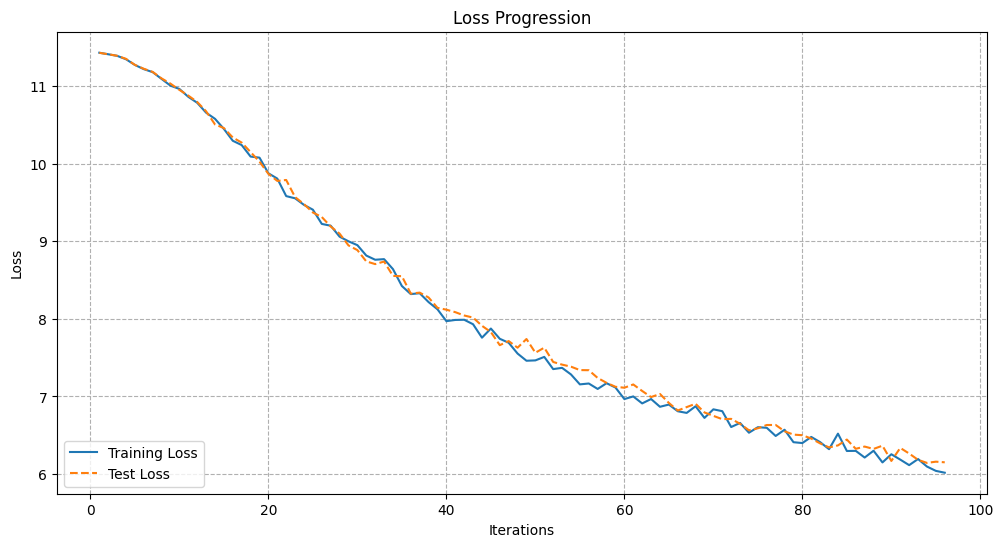

In [56]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
plt.grid(ls='--')

ax1.plot(reference_iter, train_loss_values, label='Training Loss')
ax1.plot(reference_iter, test_loss_values, label='Test Loss', linestyle='--')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Progression')

ax1.legend(loc='lower left')
plt.show()

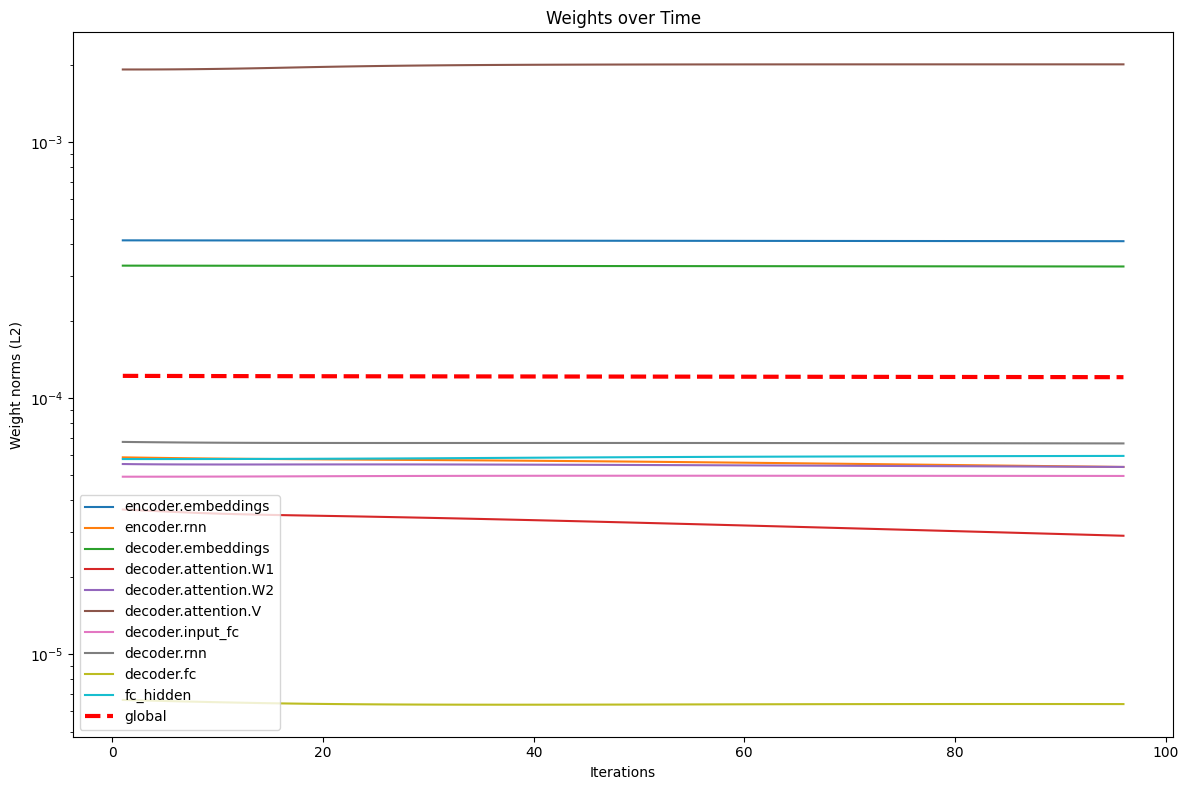

In [60]:
plt.figure(figsize=(12, 8))

for name, weights in submodule_weights.items():
    if weights:
        if name == 'global':
            plt.plot(reference_iter, weights, label=name, linewidth=3, color='red', linestyle='--')
        else:
            plt.plot(reference_iter, weights, label=name)

plt.xlabel("Iterations")
plt.ylabel("Weight norms (L2)")
plt.title("Weights over Time")
plt.legend()
plt.yscale('log')
plt.tight_layout()
plt.show()

A gradual decrease of weights typically indicates the effect of weight decay, which penalizes large weights and encourages the model to prefer smaller weights. This reduces overfitting / increases generalization.

Excessive decrease might suggest that the weight decay is too strong, causing weights to become too small. The model is restricted to capture complex data.

Large weight norms or fluctuations are undesirable.

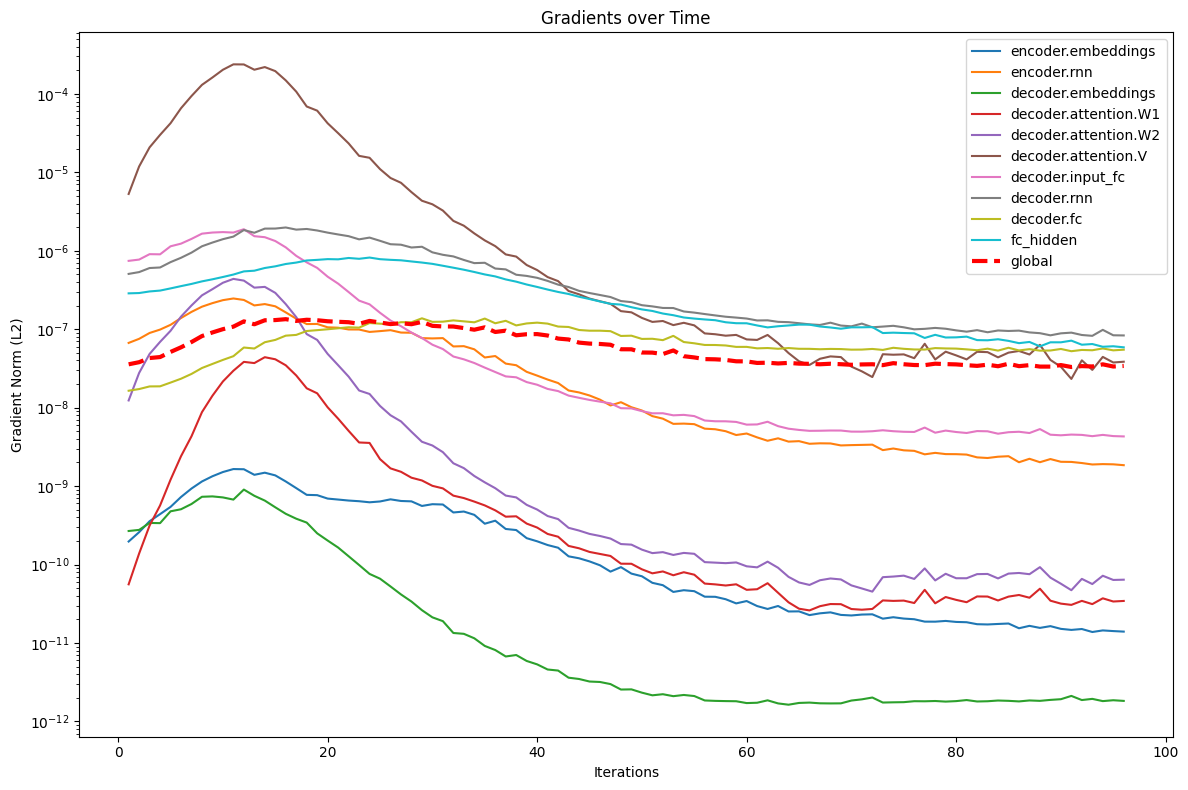

In [61]:
plt.figure(figsize=(12, 8))

for name, norms in submodule_gradients.items():
    if norms:
        if name == 'global':
            plt.plot(reference_iter, norms, label=name, linewidth=3, color='red', linestyle='--')
        else:
            plt.plot(reference_iter, norms, label=name)

plt.xlabel("Iterations")
plt.ylabel("Gradient Norm (L2)")
plt.title("Gradients over Time")
plt.legend()
plt.yscale('log')
plt.tight_layout()
plt.show()


Large gradient norms could indicate that the learning rate is too high, causing the model to take very large steps each optimization step.

If the gradients are close to zero, the model might be stuck in a (local) minima. The learning rate may be too low.

If the gradients gradually reduce during training, the model is converging as the weights are being fine-tuned with smaller updates.

Sudden spikes are not ideal.

In [ ]:
# torch.save(model.state_dict(), '../models/RNN-Attention_24-10-2024.pt')

In [ ]:
# import os.path

# if os.path.isfile('../models/RNN-Attention_24-10-2024.pt'):
#     print('Found saved state dictionary!')
#     model.load_state_dict(torch.load('../models/RNN-Attention_24-10-2024.pt'))

In [ ]:
import nltk
from nltk.tokenize import wordpunct_tokenize

# Download the tokenizer models from nltk
nltk.download('punkt')
nltk.download('punkt_tab')

def tokenize_sentence(sentence: str) -> list:
    """Tokenize a single sentence."""
    return ['<SOS>'] + wordpunct_tokenize(sentence) + ['<EOS>']


[nltk_data] Downloading package punkt to /home/ocmkieboom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ocmkieboom/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
import re

def translate(sentence, max_output_length=20):
	input_tokens = tokenize_sentence(sentence)
	input_indices = [eng_vocab.token_to_index_func(token) for token in input_tokens]

	output_indices, _ = model.evaluate(input_indices, device, max_output_length)
	output_tokens = [nld_vocab.index_to_token_func(index) for index in output_indices]

	new_sentence = ' '.join(output_tokens).capitalize()
	new_sentence = re.sub(r'\s+([.,!?])', r'\1', new_sentence)

	return new_sentence

In [ ]:
### Use model ###

print(translate('Go!'))
print(translate('It\'s not Fine.'))
print(translate('I\'m very happy today.'))
print(translate('He\'s very sad.'))
print(translate('That man is wearing a white shirt.'))
print(translate('He\'s very afraid of spiders.'))
print(translate('He\'s going home to his wife.'))
print(translate('Those guys are walking to work.'))
print(translate('I\'m not going with you today.'))
print(translate('My girlfriend will not come over tomorrow.'))
print(translate('He bought his friends a present for christmas.'))


<sos> ga ook of en door <eos> <eos> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> het <unk> <unk> niet niet niet,, niet niet <eos> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> ik <unk> <unk> <unk> zeer blij blij vandaag vandaag, <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> hij <unk> <unk> zeer zeer erg,, <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> dat man man is een een witte een een een een een van van <eos> <unk> <unk> <unk> <unk>
<sos> hij <unk> <unk> zeer bang bang van van van, <unk>. <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> hij hij <unk> <unk> huis zijn zijn vrouw vrouw vrouw naar <unk>. <unk> <unk> <unk> <unk> <unk> <unk>
<sos> die jongens worden in naar werk werk werk werk <eos> <eos> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> ik heb <unk> <unk> niet niet met met met u,, u. <unk> <unk> <unk> <unk> <unk>
<sos> mijn vriend zal niet over over over de, de op <eos> <eos> <unk> <unk> 

In [ ]:
import matplotlib.pyplot as plt

def evaluateAndShowAttention():

    # Sample a random sentence from the test data
    input_indices = random.choice(test_dataset)[0]
    input_tokens = [eng_vocab.index_to_token_func(index) for index in input_indices.tolist()]

    output_indices, attentions = model.evaluate(input_indices, device)
    output_indices = output_indices[1:] # Remove single batch dimension
    output_tokens = [nld_vocab.index_to_token_func(index) for index in output_indices]

    output_tokens.insert(0, "<SOS>")

    attentions = attentions.cpu().numpy()

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='plasma')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(range(len(input_tokens)))
    ax.set_yticks(range(len(output_tokens)))

    ax.set_xticklabels(input_tokens, rotation=90)
    ax.set_yticklabels(output_tokens)

    plt.show()

/home/ocmkieboom/Projecten/vscode_notebooks/src/RNN/Seq2Seq.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(ixs, device=device).unsqueeze(0) # tensor: [1, seq_len]


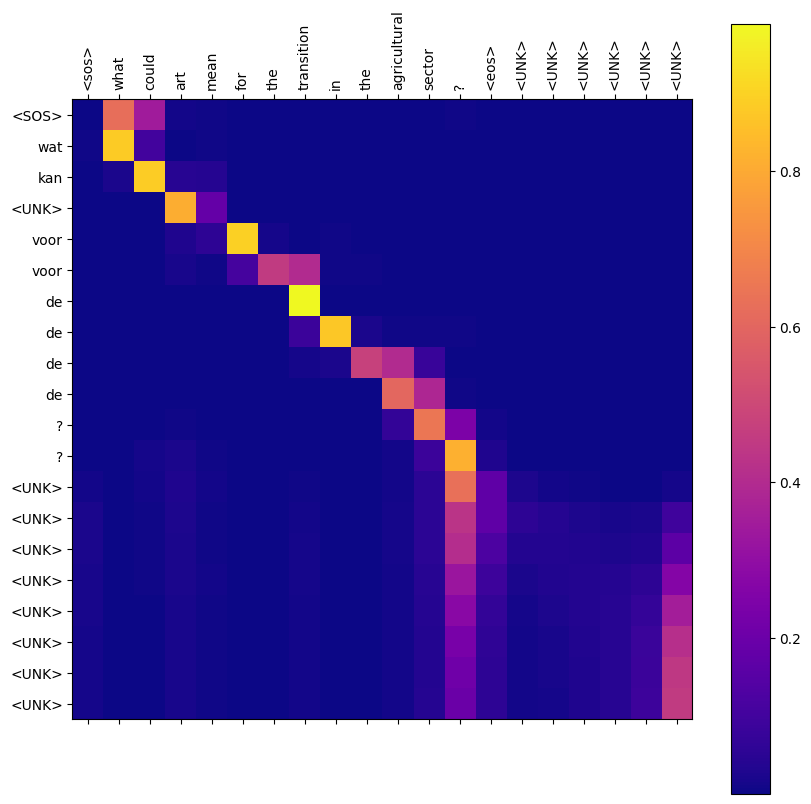

In [ ]:
evaluateAndShowAttention()